In [1]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
import os
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
import tensorflow.compat.v1 as tf
import tensorflow as tf

/Users/little/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def get_data(code, date):
    df = web.get_data_yahoo(code, datetime.date(2019,1,1), end=date)
    
    # Change all column headings to be lower case, and remove spacing
    df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
    
    return df

In [3]:
def preprocess(stock_data, day, seq_length, data_dim, output_dim, visual_window):
    # Data Prepariation to 3D array
    xy = stock_data[['open', 'close', 'high', 'low', 'volume']] #extract features
    xy = np.array(xy.values) #convert to array

    # Data Range: 0 ~ length(df)-seq_length-day+1
    dataXY = []
    for i in range(0, len(xy) - seq_length - day + 1):
        _xy = xy[i:i + seq_length + day]
        dataXY.append(_xy)  
    # reshape dataXY
    dataXY = np.vstack(dataXY).reshape(-1, seq_length + day, data_dim)
    
    # Predicted Price in 'day' days
    app_dataX = xy[len(xy)-seq_length:len(xy)]
    app_dataX = np.vstack(app_dataX).reshape(-1, seq_length, data_dim)
    
    xy_visual = dataXY
    
    # split to train and testing
    train_size = int(len(dataXY) * 0.7)
    test_size = len(dataXY) - train_size
    xy_train, xy_test = np.array(dataXY[0:train_size]), np.array(dataXY[train_size:len(dataXY)])
    
    # Scaled train data
    scaler = MinMaxScaler()
    xy_train = xy_train.reshape((-1, data_dim)) #transfer train data to 2D
    xy_train_new = scaler.fit_transform(xy_train) #scale the train data by column, in each column, min=0, max=1
    xy_train_new = xy_train_new.reshape((-1, seq_length + day, data_dim))  #transfer train data to 3D
    
    trainX = xy_train_new[:,0:seq_length] #trainX is the stock price of each first seq_length days
    trainY = xy_train_new[:,-1,1]  #trainY is the close price of each last day
    
    # Scaled test data
    xy_test = xy_test.reshape((-1, data_dim))
    xy_test_new = scaler.transform(xy_test) #use the scaler of train data to scale test data
    xy_test_new = xy_test_new.reshape((-1, seq_length + day, data_dim))
    
    testX = xy_test_new[:, 0:seq_length]
    testY = xy_test_new[:, -1, 1]
    
    # Scale the last 'day' day stock price
    x_app = app_dataX.reshape((-1, data_dim)) #transfer to 2D
    appX = scaler.transform(x_app) #use the scaler of train data to scale app data
    appX = appX.reshape((-1, seq_length, data_dim)) 
    
    # prices for calculating strategy's income
    close_price = xy_test_new[:, seq_length - 1, 1] #close price of No.seq_length day
    buy_price = xy_test_new[:, seq_length, 0] #open price of No.seq_length+1 day
    sell_price = xy_test_new[:, -1, 1] #close price of the last day
    last_day_close_price = appX[:,seq_length-1, 1]
   
    visualX, visualY = trainX, trainY

    return trainX, trainY, testX, testY, appX, scaler, close_price, buy_price, sell_price, visualX, visualY, last_day_close_price


In [45]:
from keras.layers import Input, Dense, LSTM, Reshape
from keras.models import Model
from keras import regularizers, callbacks

def train(code, day, trainX, trainY, seq_length, data_dim, output_dim):
    # 构建神经网络层 1层Dense层+1层LSTM层+4层Dense层
    rnn_units = 32
    Dense_input = Input(shape=(seq_length, data_dim), name='dense_input') #输入层
    #shape: 形状元组（整型）不包括batch size。表示了预期的输入将是一批（seq_len,data_dim）的向量。
    Dense_output_1 = Dense(rnn_units, activation='relu', kernel_regularizer=regularizers.l2(0.0), name='dense1')(Dense_input) #全连接网络

    lstm_input = Reshape(target_shape=(seq_length, rnn_units), name='reshape2')(Dense_output_1) 
    #改变Tensor形状，改变后是（None，seq_length, rnn_units）
    lstm_output = LSTM(rnn_units, activation='tanh', dropout=1.0, name='lstm')(lstm_input) #LSTM网络
    #units: Positive integer,dimensionality of the output space.
    #dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
    
    
    Dense_input_2 = Reshape(target_shape=(rnn_units,), name='reshape3')(lstm_output) 
    #改变Tensor形状，改变后是（None，rnn_units）
    Dense_output_2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0), name='dense2')(Dense_input_2) #全连接网络
    Dense_output_3 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0), name='dense3')(Dense_output_2) #全连接网络
    Dense_output_4 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0), name='dense4')(Dense_output_3) #全连接网络
    predictions = Dense(output_dim, activation=None, kernel_regularizer=regularizers.l2(0.0), name='dense5')(Dense_output_4) #全连接网络

    model = Model(inputs=Dense_input, outputs=predictions)
    #This model will include all layers required in the computation of output given input.
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    #Configures the model for training.
    #optimizer: String (name of optimizer) or optimizer instance. See optimizers.
    #loss: String (name of objective function) or objective function.The loss value will be minimized by the model.
    #metrics: List of metrics to be evaluated by the model during training and testing. Typically you will use  metrics=['accuracy'].
    
    ES = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None)
    
    model.fit(trainX, trainY, batch_size=256, epochs=400, verbose=0, callbacks=[ES], validation_split=0.1)
    #Trains the model for a given number of epochs (iterations on a dataset).
    #verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
    
    # 保存模型
    #model.save(code + '(1)' + str(day) + '.h5')   # HDF5文件，pip install h5py
    
    return model


In [4]:
from keras.layers import Input, Dense, LSTM, Reshape
from keras.models import Model
from keras import regularizers, callbacks
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

def train(code, day, trainX, trainY, seq_length, data_dim, output_dim):

    # parameters
    epochs = 400
    batch_size = 256
    # LSTM parameters: return_sequences=True - the output of LSTM is a sequence; False，the output of LSTM is a number
    # input_dim：dimension of input data
    # input_length：time length of input data
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_dim=trainX.shape[-1], input_length=trainX.shape[1]))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
    
    
    return model

Using TensorFlow backend.


In [8]:
def test(model, testX, testY, scaler, day, close_price, buy_price, sell_price, visualX, visualY):
    # Fit the model on the test data
    testPredict = model.predict(testX)
    # Scale back the predicted price and the actual price
    testPredict2 = testPredict * scaler.data_range_[:1] + scaler.data_min_[:1]
    testY2 = testY * scaler.data_range_[:1] + scaler.data_min_[:1]
    
    # Scale back the buy price & sell price
    # close_price: for comparison with the predicted price
    close_price2 = close_price * scaler.data_range_[:1] + scaler.data_min_[:1]
    # purchase price: the open price of the no.seq_length day
    buy_price2 = buy_price * scaler.data_range_[:1] + scaler.data_min_[:1]
    # selling price: the close price of the no.(seq_length+day) day
    sell_price2 = sell_price * scaler.data_range_[:1] + scaler.data_min_[:1]
    
    # Error
    result = pd.DataFrame({'Prediction': testPredict2[:,0],'Close': testY2})
    rmse = ((result.Prediction - result.Close) ** 2).mean() ** 0.5
    #print('RMSE is: %.2f' %rmse)
    
    count = 0 #count number of error which is smaller than 1%
    correct = np.zeros(len(testPredict2)) #count the number of correct predicting the trend
    model_income = 10000 #count the gain of the strategy
    initial_inv = model_income
    trade = 0 #number of trading days
    tolerance = 1

    for i in range(len(testY2)):
        #count number of error which is smaller than 1%
        if abs(testPredict2[i] - testY2[i]) / testY2[i] * 100 <= tolerance:
            count += 1
        #count the number of correct predicting the trend
        if np.sign(testPredict2[i] - close_price2[i]) == np.sign(testY2[i] - close_price2[i]):
            correct[i] = 1
        #if the predicted price of 'day'th day is higher than today's close price, then trade in
        if testPredict2[i] > close_price2[i]:
            model_income = model_income + sell_price2[i] - buy_price2[i]
            trade += 1
            
    rate_return = (model_income-initial_inv)/initial_inv
    print('Model Income:', model_income)
    print('Rate of Return: %f%%' %round(rate_return*100,2))
    print('Number of Days:', len(close_price2))
    print('Number of Trading days:', trade)
    print('Number of Correct Predicting Trend:', correct.sum())
    
    visualPredict = model.predict(visualX)
    visualPredict2 = visualPredict * scaler.data_range_[:1] + scaler.data_min_[:1] #放大和scale的逆运算
    visualY2 = visualY * scaler.data_range_[:1] + scaler.data_min_[:1] #放大和scale的逆运算
    
    return testY2, testPredict2

In [13]:
def apply(model, appX, scaler, day, last_day_close_price):
    # The latest 10 days' prediction
    appPredict = model.predict(appX)
    # Scale back & reshape
    appPredict2 = appPredict * scaler.data_range_[:1] + scaler.data_min_[:1]
    appPredict2 = appPredict2.reshape(-1)
    
    # Scale back close price
    last_close_price2 = last_day_close_price * scaler.data_range_[:1] + scaler.data_min_[:1]

    Trade_Decision = 'Hold'
    if appPredict2[0] > last_close_price2[0]: 
        Trade_Decision = 'Buy'
    if appPredict2[0] == last_close_price2[0]: 
        Trade_Decision = 'Hold'
    if appPredict2[0] < last_close_price2[0]: 
        Trade_Decision = 'Sell'

    print("Future %i day's stock price: %f" %(int(day), round(appPredict2[0],2)))
    print("Today's close price:", round(last_close_price2[0],2))
    print("Trade Decision:", Trade_Decision)
    
    return appPredict2

In [19]:
import matplotlib.pyplot as plt
def visualize(testY2, testPredict2, appPredict2, visual_window, day):
    
    visual_window = 100
    plt.figure(figsize=(14,7))
    plt.scatter(
            list(range(len(testPredict2)+day, len(testPredict2)+day + len(appPredict2))), appPredict2, color='red')  
    plt.plot(list(range(len(testY2))), testY2, color='blue')
    plt.plot(list(range(len(testPredict2))), testPredict2, color='orange')
  
    plt.xlim((0, visual_window + day))
    plt.legend(['True price', 'Model result', 'Prediction'], loc='upper left')
    plt.ylabel('price')
    plt.xlabel('time')
    plt.show()
    #plt.figure(figsize=(14,7)) #画布大小
    #plt.plot(list(range(len(testY2))), testY2, color='blue') #只显示最近“period”天的测试记录
    #plt.plot(list(range(len(testPredict2))), testPredict2, color='orange')
    #plt.scatter(
   #     list(range(len(testPredict2)+day, len(testPredict2)+day + len(appPredict2))), appPredict2, color='red')  
   # plt.xlim((0, visual_window + day)) #x坐标范围
   # plt.legend(['True price', 'Model result', 'Prediction'], loc='upper left')
   # plt.ylabel('price')
   # plt.xlabel('time')
    plt.show()


In [29]:
def main():
    code = input("Please enter the ticker:") #输入股票代码    
    day = input("Number of Prediction Day：") #输入预测多少天后的价格
    day = int(day)
    
    #import time
    date = datetime.date.today() # get today's date
    
    #参数设置/parameter setting
    timesteps = seq_length = 20 #时间窗/window length
    data_dim = 5 #输入数据维度/dimension of input data
    output_dim = 1 #输出数据维度/dimension of output data
    visual_window = 100
    
    try:
        stock_data = get_data(code, date)
    except:
        print('Wrong ticker')
        return
    if len(stock_data) == 0:
        print('Wrong ticker')
        return
    
    trainX, trainY, testX, testY, appX, scaler, test_close, test_buy, test_sell, visualX, visualY, last_day_close_price = preprocess(
        stock_data, day, seq_length, data_dim, output_dim, visual_window)
    
   # try:
        # 载入模型
        #from keras.models import load_model
        #model = load_model(code + '(1)' + str(day) + '.h5')
    #except:
    print('Predict future %d days '%(day) + code + ' stock price，we need some time.')
    model = train(
            code, day, trainX, trainY, seq_length, data_dim, output_dim)
    
    visualY2, visualPredict2 = test(model, testX, testY, scaler, day, test_close, test_buy, test_sell, visualX, visualY)
    appPredict2 = apply(model, appX, scaler, day, last_day_close_price)
    visualize(visualY2, visualPredict2, appPredict2, visual_window, day)

In [25]:
stock_data = get_data('AAPL',datetime.date.today() )
#参数设置/parameter setting
timesteps = seq_length = 20 #时间窗/window length
data_dim = 5 #输入数据维度/dimension of input data
output_dim = 1 #输出数据维度/dimension of output data
visual_window = 320
day = 20
trainX, trainY, testX, testY, appX, scaler, test_close, test_buy, test_sell, visualX, visualY, last_day_close_price = preprocess(
        stock_data, day, seq_length, data_dim, output_dim, visual_window)

In [6]:
        model = train(
            'AAPL', 10, trainX, trainY, seq_length, data_dim, output_dim)

In [9]:
    visualY2, visualPredict2 = test(model, testX, testY, scaler, day, test_close, test_buy, test_sell, visualX, visualY)


Model Income: 10371.189137698104
Rate of Return: 3.710000%
Number of Days: 93
Number of Trading days: 73
Number of Correct Predicting Trend: 56.0


In [15]:
    appPredict2 = apply(model, appX, scaler, day, last_day_close_price)


Future 20 day's stock price: 303.010000
Today's close price: 303.33
Trade Decision: Sell


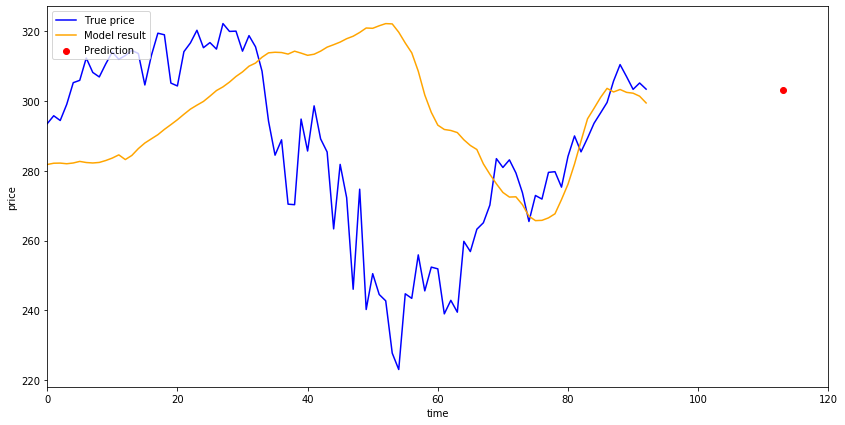

In [20]:
    visualize(visualY2, visualPredict2, appPredict2, visual_window, day)

Please enter the ticker:AAPL
Number of Prediction Day：20
Predict future 20 days AAPL stock price，we need some time.
Model Income: 10309.097434101
Rate of Return: 3.090000%
Number of Days: 93
Number of Trading days: 76
Number of Correct Predicting Trend: 55.0
Future 20 day's stock price: 304.260000
Today's close price: 303.33
Trade Decision: Buy


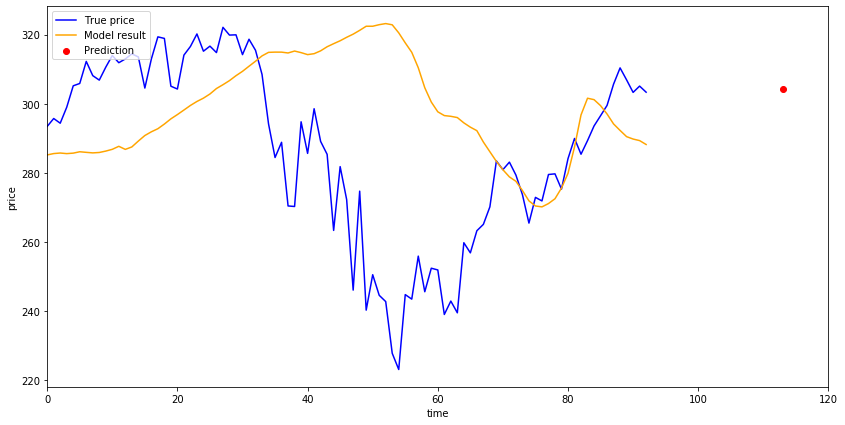

In [30]:
main()